# High content quantum yield 

In [3]:
import os
import pandas as pd
import numpy as np


In [8]:
cd C:\Users\hwbst6\DataTime\HCQY\high_content_quantum_yield\tw_hcqy_13102023

C:\Users\hwbst6\DataTime\HCQY\high_content_quantum_yield\tw_hcqy_13102023


In [5]:
pwd

'C:\\Users\\hwbst6\\DataTime\\HCQY\\high_content_quantum_yield'

## Import data
### UV/Vis and fluorescence data

In [40]:
#script for converting *.xlsx or csv data to a neat UV/vis forma

def spec_import(spec_sht_name):
    #spec_sht_name this is varible for sheet name/experiment number
    #sps_name = "RNA Quantior-003- 5-7-22.xlsx" # this is the spread sheet name if your using a spread sheet
    spec_inp= pd.DataFrame()
    #load in plate reader output uncomment the one you want to use
    try:
        # use this if your reading in from a multisheet excel
        #_inp = pd.read_excel(sps_name, sheet_name = sht_name)

        # use this if your reading from a *csv file
        spec_inp = pd.read_csv(spec_sht_name + '.csv')
    except PermissionError:
        print('The file we are trying to open may be open in another program, please close and try again!')
    try: #transpose and remove some columns, these may need changeing
        spec_inp = pd.DataFrame.transpose(spec_inp)
        spec_inp = spec_inp.drop(axis=1, columns=[0,1,2,3])
        #print(_inp)
    except KeyError:
        print('Check the your input file!') 
    try:    #_inp.sort_index()
        spec_inp = spec_inp.reset_index(drop=True)
        #build well name and remove related columns
        spec_inp.iloc[0:,1] = spec_inp.iloc[0:,1].astype(str)
        spec_inp.iloc[0:,2] = spec_inp.iloc[0:,0].astype(str) + spec_inp.iloc[0:,1].astype(str)
        spec_inp = spec_inp.drop(axis=1, columns=[4,5])
        spec_inp = pd.DataFrame.drop(spec_inp,axis=0, index=0)
        spec_inp.iloc[0,0] = "Well"
    except IndexError:
        print('Check the your input file!')
    try:     
        spec_inp.rename(columns= spec_inp.iloc[0,0:], inplace=True) # set row 0 as col titles
        spec_inp = spec_inp.reset_index(drop=True)
        spec_inp = pd.DataFrame.drop(spec_inp, axis=0, index=0)
        spec_inp = spec_inp.reset_index(drop=True)
    except KeyError:
        print('Check the your input file!')
    try: #output results
        spec_inp.to_csv("hcqy__dat_" + spec_sht_name + ".csv",index=False)
    except PermissionError:
        print('The file we are trying to open may be open in another program, please close and try again!')
    return spec_inp



In [38]:
# Plot and calculate gradients for Chris's optimised plate map
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statistics
from tabulate import tabulate

def plot_calc(abs_inp, flu_inp):
    hcqy_plot= pd.DataFrame()

    ps_lst = ["TPP","C5","C6","C7"]

    exp_points = 5
    num_ps = 4
    num_rep = 4
    abs_wav_len_start = 400
    exc_wav_len = 516

    # setup columns
    hcqy_plot.insert(0,"PS", range(0,(exp_points*num_ps)))
    for p in range(0,len(ps_lst)):
        hcqy_plot.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]

    # define excitation wavelength
    exc_col_num = int((exc_wav_len - abs_wav_len_start) / 2)

    # populates experiemnt names and data point names
    # add abs values at excitation wavelength
    hcqy_plot["ex_abs_1"], hcqy_plot["ex_abs_2"], hcqy_plot["ex_abs_3"], hcqy_plot["ex_abs_4"]  = [0, 0, 0, 0]
    hcqy_plot["ex_int_flu_1"], hcqy_plot["ex_int_flu_2"], hcqy_plot["ex_int_flu_3"], hcqy_plot["ex_int_flu_4"]  = [0, 0, 0, 0]

    # populate corrected abs
    #selecting columns to convet to numeric using df.columns
    cols = abs_inp.columns.drop('Well')
    abs_inp[cols] = abs_inp[cols].apply(pd.to_numeric, errors='coerce')

    # add abs values at excitation wavelength
    for x in range(0,(num_rep)):
        for p in range(0,len(ps_lst)):
            #print(p*exp_points)
            n=0 
            g = 0
            if p >= 2:
                g=36
            while n <= (exp_points-1): 
                hcqy_plot.iloc[(p*exp_points+n),x+1] = abs_inp.iloc[(p*exp_points+n+1+p+x*12+g),exc_col_num]
                n = n +1

    #selecting columns to convet to numeric using df.columns
    cols = flu_inp.columns.drop('Well')
    flu_inp[cols] = flu_inp[cols].apply(pd.to_numeric, errors='coerce')

    # populate integrated fluorescence intensities
    for x in range(0,(num_rep)):
        for p in range(0,len(ps_lst)):
            #print(p*exp_points)
            n=0 
            g = 0
            if p >= 2:
                g=36
            while n <= (exp_points-1): 
                #hcqy_plot.iloc[(p*exp_points+n),x+5] = flu_inp.iloc[(p*exp_points+n+1+p+x*12+g),0]
                hcqy_plot.iloc[(p*exp_points+n),x+5] = flu_inp.iloc[(p*exp_points+n+1+p+x*12+g),1:].sum()
                n = n +1
    print(hcqy_plot)            
    # set up gradiant data frame with experiemnt by experiemnt possitions
    hcqy_grad = pd.DataFrame()
    hcqy_grad.insert(0,"PS", range(0,(num_rep*num_ps)))
    for p in range(0,len(ps_lst)):
        hcqy_grad.iloc[(p*num_rep):(p*(num_rep))+num_rep] = ps_lst[p]
    hcqy_grad["grad_abs_flu"]  = 0
    hcqy_grad["grad_R^2"]  = 0
    hcqy_grad["grad_intercept"]  = 0
    hcqy_grad["flu_QY"]  = 0


    # populate gradiant data frame
    for p in range(0,len(ps_lst)):
        #per PS
        for x in range(0,(num_rep)):
            #per rep
            x_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+1]).reshape((-1, 1))
            y_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+5])
            qy_grad = LinearRegression().fit(x_lr, y_lr)
            hcqy_grad.iloc[x+p*num_rep,1] =  qy_grad.coef_[0]
            hcqy_grad.iloc[x+p*num_rep,2] =  qy_grad.score(x_lr, y_lr)
            hcqy_grad.iloc[x+p*num_rep,3] =  qy_grad.intercept_

    # QC on gradient data frame

    # prep for QY calc collect standard QY values and check solvents
    # take mean of standard gradient
    st_grad = statistics.mean(hcqy_grad.iloc[0:4,1])

    # calculate QYs move to QY df
    st_qy = 0.1 # check value
    for p in range(1,len(ps_lst)):
        #per PS
        for x in range(0,(num_rep)):
            #per rep
            hcqy_grad.iloc[x+p*num_rep,4] = st_qy*((hcqy_grad.iloc[x+p*num_rep,1])/st_grad)*(1**2/1**2)

    #print(list(hcqy_qy.columns))

    hcqy_qy = pd.DataFrame()
    hcqy_qy.insert(0,"PS", range(0,num_ps-1))
    hcqy_qy["\u03A6x"]  = 0
    hcqy_qy["\u03C3"]  = 0
    hcqy_qy["2\u03C3"]  = 0
    hcqy_qy["% error at \u03C3"]  = 0
    hcqy_qy["% error at 2\u03C3"]  = 0
    for p in range(1,len(ps_lst)):
        hcqy_qy.iloc[(p-1),0] = ps_lst[p]
        hcqy_qy.iloc[(p-1),1] = statistics.mean(hcqy_grad.iloc[p*4:p*4+5,4])
        hcqy_qy.iloc[(p-1),2] = statistics.stdev(hcqy_grad.iloc[p*4:p*4+5,4])
        hcqy_qy.iloc[(p-1),3] = 2 * hcqy_qy.iloc[(p-1),2]
        hcqy_qy.iloc[(p-1),4] = (hcqy_qy.iloc[(p-1),2] / hcqy_qy.iloc[(p-1),1]) * 100
        hcqy_qy.iloc[(p-1),5] = (hcqy_qy.iloc[(p-1),3] / hcqy_qy.iloc[(p-1),1]) * 100

    hcqy_qy = hcqy_qy.reset_index(drop=True)    
    print(tabulate(hcqy_qy, headers=hcqy_qy.columns, tablefmt="github", showindex=False))   

    # generate plots 
    # raw abd vs. int flu labled
    mark_lst = ["o", "v", "h", "p"]
    colour_lst = ["black", "blue", "green", "purple"]
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    #loops to generate number of PS * number of repeats plots
    for p in range(0,len(ps_lst)):
        if p == 0 or p == 1:
            px = 0
        else:
            px = 1
        if p == 0 or p == 2:
            py = 0
        else:
            py = 1
        plt.title(f'HCQY for {ps_lst[p]}', pad=5)
        for x in range(0,(num_rep)):
            # plot design
            #plt.title(f'HCQY for {ps_lst[p-1]}', pad=5)
            x_1 = hcqy_plot.iloc[p*5:(5+p*5),x+1]
            y_1 = hcqy_plot.iloc[p*5:(5+p*5),x+5]
            plt.subplot(2, 2, p+1)
            ax[px,py].scatter(x_1, y_1,s=30, facecolors='none', edgecolors=colour_lst[p], linewidths=2.0, marker = mark_lst[x])
            plt.xlim(0,(1.2*max(x_1)))
            plt.ylim(0,(1.2*max(y_1)))
            plt.xlabel("Absorbance")
            plt.ylabel("Integrated FU ")
    fig.tight_layout()
    plt.show()
    return



     PS  ex_abs_1  ex_abs_2  ex_abs_3  ex_abs_4  ex_int_flu_1  ex_int_flu_2  \
0   TPP     0.144     0.141     0.159     0.165      14524192      14398282   
1   TPP     0.104     0.110     0.108     0.111       9080515      11198918   
2   TPP     0.077     0.118     0.095     0.073       6152878       5878280   
3   TPP     0.056     0.059     0.057     0.055       2958799       3672397   
4   TPP     0.044     0.043     0.123     0.050       1515327       1469500   
5    C5     0.349     0.356     0.373     0.369      34159551      36828600   
6    C5     0.242     0.244     0.253     0.256      23569200      27353362   
7    C5     0.144     0.136     0.137     0.156      13534371      14775022   
8    C5     0.095     0.121     0.095     0.113       6901846       7074285   
9    C5     0.068     0.035     0.091     0.075       2859116        490640   
10   C6     0.395     0.406     0.407     0.398      38090287      41023313   
11   C6     0.277     0.288     0.282     0.298     

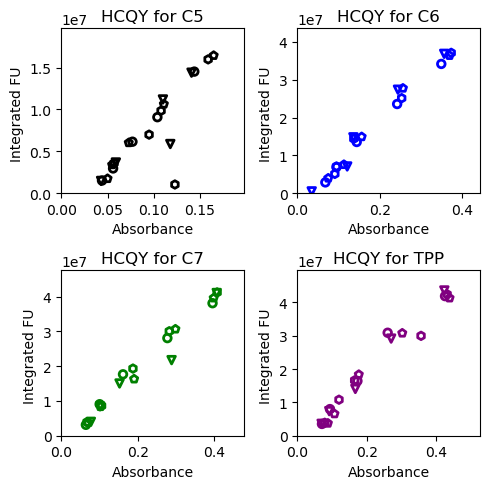

In [41]:
#importing spectra UV/vis and fluorescence

abs_input = "TRno4895" # name of abs input file from clario star

flu_input = "TRno4897" # name of abs input file from clario star

abs_inp = spec_import(abs_input)
flu_inp = spec_import(flu_input)

#print(abs_inp.head(3))
#print(flu_inp.head(3))

plot_calc(abs_inp, flu_inp)